      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ   0.1817 0.0001  0.0676  0.2959   True
        CsCh     LDA_5DIZ   0.0794  0.271 -0.0295  0.1883  False
        CsCh LDA_OCT_5DIZ   0.5911    0.0  0.4543   0.728   True
        CsCh     OCT_5DIZ   0.3548    0.0  0.2391  0.4705   True
     Cs_5DIZ     LDA_5DIZ  -0.1023 0.0973 -0.2154  0.0107  False
     Cs_5DIZ LDA_OCT_5DIZ   0.4094    0.0  0.2693  0.5496   True
     Cs_5DIZ     OCT_5DIZ   0.1731 0.0008  0.0535  0.2927   True
    LDA_5DIZ LDA_OCT_5DIZ   0.5118    0.0  0.3758  0.6477   True
    LDA_5DIZ     OCT_5DIZ   0.2754    0.0  0.1608    0.39   True
LDA_OCT_5DIZ     OCT_5DIZ  -0.2364 0.0001 -0.3778 -0.0949   True
----------------------------------------------------------------


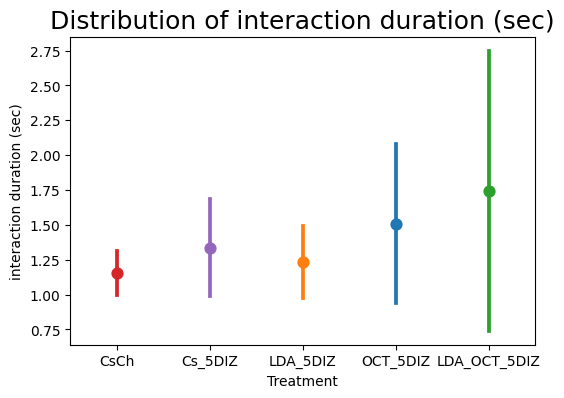

KeyError: 'interaction rate (interactions/min)Betweenness centrality w=count'

In [1]:
import os
import toml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

from src import settings
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, "main.toml")
with open(CONFIG_PATH, "r") as file:
    config = toml.load(file)  
INPUT_PATH = os.path.join(settings.RESULTS_DIR, "local_measures")
all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key in config["TREATMENTS"]}

treatment_dataframes = pd.DataFrame()
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_files_from_folder(treatment_path)

    for group_name, group_path in all_groups.items():
        df = pd.read_csv(group_path, index_col=0)
        df.rename_axis("Fly")
        df['Treatment'] = treatment_name
        df['Group'] = group_name.replace(".csv", "")
        treatment_dataframes = pd.concat([treatment_dataframes, df])

treatment_dataframes = treatment_dataframes.set_index('Treatment', append=True)
treatment_dataframes = treatment_dataframes.set_index('Group',append=True)
combined_data_reset = treatment_dataframes.reset_index()

combined_data_reset["interaction duration (sec)"] = combined_data_reset["Weighted Degree (duration(seconds))"]/combined_data_reset['Weighted Degree (count)']
combined_data_reset["interaction rate (interactions/min)"] = combined_data_reset['Weighted Degree (count)'] / (config['EXPERIMENT_DURATION']/60)

measures = [
    'interaction duration (sec)',
    'interaction rate (interactions/min)',

    'Betweenness centrality w=count',
    'Betweenness centrality w=duration(seconds)',
    
    'Weighted Degree (count)',
    'Weighted Degree (duration(seconds))',
    'Clustering coefficient w=count',
    'Clustering coefficient w=duration(seconds)',
]

for measure_name in measures:
    treatment_sums = {}
    for treatment in config['TREATMENTS']:
        treatment_sums[f'sum_{treatment}'] = combined_data_reset[combined_data_reset['Treatment'] == treatment][measure_name]

    anova_result = scipy.stats.f_oneway(*treatment_sums.values())

    all_data = np.concatenate([*treatment_sums.values()])
    group_labels = []
    for treatment in config['TREATMENTS']:
        group_labels.extend([treatment] * len(combined_data_reset[combined_data_reset['Treatment'] == treatment][measure_name]))

    tukey_results = pairwise_tukeyhsd(all_data, group_labels)

    # if any(tukey_results.reject):
    print(tukey_results)

    plt.figure(figsize=(6, 4))
    sns.pointplot(data=combined_data_reset, x='Treatment', y=measure_name, hue='Treatment', errorbar='sd', order=config['TREATMENTS'])
    # sns.boxplot(data=combined_data_reset, x='Treatment', y=measure_name, hue='Treatment', order=order)
    
    plt.xlabel('Treatment')
    plt.ylabel(measure_name)
    plt.title(f'Distribution of {measure_name}', fontsize=18)
    plt.legend().remove()
    plt.show() 


In [3]:
combined_data_reset.columns

Index(['level_0', 'Treatment', 'Group', 'Weighted degree w=count',
       'Weighted degree w=duration', 'Degree centrality',
       'In-degree centrality', 'Out-degree centrality',
       'Eigenvector centrality', 'Closeness centrality',
       'In-Strength distribution, w=count',
       'Out-Strength distribution, w=count',
       'In-Strength distribution, w=duration',
       'Out-Strength distribution, w=duration', 'Weighted Degree (count)',
       'Weighted Degree (duration(seconds))', 'In-degree', 'Out-degree',
       'Selectivity', 'Betweenness centrality w=None',
       'Betweenness centrality w=count',
       'Betweenness centrality w=duration(seconds)',
       'Clustering coefficient w=None', 'Clustering coefficient w=count',
       'Clustering coefficient w=duration(seconds)', 'PageRank centrality',
       'interaction duration (sec)', 'interaction rate (interactions/min)'],
      dtype='object')